In [1]:
import scanpy as sc
import torch
import lightning.pytorch as pl
from torch import nn
from torch.optim import AdamW
from self_supervision.models.lightning_modules.cellnet_autoencoder import MLPAutoEncoder
from self_supervision.estimator.cellnet import EstimatorAutoEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
import pandas as pd

data_dir = '../../dataset/merfish_human_neocortex_SSL.h5ad'
adata = sc.read_h5ad(data_dir)
adata.X = adata.raw.X.copy()
print(adata.X)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)


# 2. 设置 checkpoint 路径
ckpt_path = "../../sc_pretrained/Pretrained Models/RandomMask.ckpt"

# 3. 模型参数
units_encoder = [512, 512, 256, 256, 64]
units_decoder = [256, 256, 512, 512]

# 初始化 EstimatorAutoEncoder 实例
estim = EstimatorAutoEncoder(data_path=None)  # 没有实际数据路径，可以设置为None

# 4. 加载预训练模型
estim.model = MLPAutoEncoder.load_from_checkpoint(
    ckpt_path,
    gene_dim=19331,  # 根据你的数据调整
    batch_size=8192,  # 根据你的需要调整
    units_encoder=units_encoder, 
    units_decoder=units_decoder,
    masking_strategy="random",  # 假设模型使用了随机掩码
    masking_rate=0.5,  # 根据需要调整
)

/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")
/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/triton.py:53: UserWarning: Triton dtype mappings did not load successfully due to an error: No module named 'tritonclient'
  warn(f"Triton dtype mappings did not load successfully due to an error: {exc.msg}")


<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 12532157 stored elements and shape (234125, 300)>
  Coords	Values
  (0, 9)	5
  (0, 16)	2
  (0, 18)	3
  (0, 23)	1
  (0, 24)	1
  (0, 25)	5
  (0, 27)	1
  (0, 28)	1
  (0, 29)	6
  (0, 30)	1
  (0, 31)	1
  (0, 34)	6
  (0, 37)	1
  (0, 45)	21
  (0, 46)	1
  (0, 53)	1
  (0, 58)	1
  (0, 60)	1
  (0, 61)	1
  (0, 67)	2
  (0, 68)	1
  (0, 74)	1
  (0, 81)	1
  (0, 86)	1
  (0, 87)	2
  :	:
  (234123, 261)	1
  (234124, 14)	2
  (234124, 18)	1
  (234124, 25)	3
  (234124, 55)	1
  (234124, 58)	1
  (234124, 62)	1
  (234124, 66)	1
  (234124, 75)	1
  (234124, 89)	1
  (234124, 104)	1
  (234124, 106)	1
  (234124, 107)	1
  (234124, 117)	2
  (234124, 126)	1
  (234124, 146)	3
  (234124, 171)	1
  (234124, 184)	1
  (234124, 200)	1
  (234124, 215)	3
  (234124, 221)	1
  (234124, 237)	1
  (234124, 251)	1
  (234124, 261)	1
  (234124, 297)	1


In [2]:
# 添加分类层 (FC)
n_classes = len(adata.obs['cell_type'].unique())
estim.model.fc = nn.Linear(units_encoder[-1], n_classes)
n_classes

29

In [3]:
var_df = pd.read_parquet('../../sc_pretrained/var.parquet')
all_genes = var_df['feature_name'].tolist()

new_data = np.zeros((adata.X.shape[0], len(all_genes)), dtype=np.float32)

adata.var['gene_name']=adata.var.index
existing_genes = adata.var['gene_name']

In [4]:
# 将所有基因名称转换为小写
all_genes_lower = [gene.lower() for gene in all_genes]
adata_genes_lower = [gene.lower() for gene in existing_genes]

# 将两个列表转换为集合
all_genes_set = set(all_genes_lower)
adata_genes_set = set(adata_genes_lower)

# 计算交集
matching_genes = all_genes_set.intersection(adata_genes_set)
matching_count = len(matching_genes)
# 计算不匹配的基因
non_matching_genes = adata_genes_set - matching_genes
non_matching_count = len(non_matching_genes)


# 输出结果
print(f"匹配的基因数量: {matching_count}")
print(f"匹配的基因列表: {matching_genes}")
non_matching_genes

匹配的基因数量: 281
匹配的基因列表: {'bnip3', 'tfrc', 'col24a1', 'itih5', 'ltbp1', 'gli3', 'reln', 'cfap54', 'ccn1', 'srrm4', 'cfap299', 'prox1', 'kcnq5', 'tshr', 'nwd2', 'ccser1', 'dock10', 'cntln', 'st8sia5', 'tfap2c', 'ebf2', 'prss12', 'olfm3', 'cdh9', 'trhde', 'hgf', 'pcsk6', 'sema5a', 'abcb1', 'hopx', 'ca10', 'cpne8', 'plp1', 'gad1', 'id3', 'hcrtr2', 'apbb1ip', 'kcnh5', 'satb2', 'synpr', 'disc1', 'svil', 'opcml', 'enpp6', 'cdh18', 'grm3', 'il1rapl2', 'cd38', 'pou3f2', 'slco1c1', 'stk32b', 'kif11', 'nxph2', 'ttr', 'pcdh15', 'ebf1', 'dgkd', 'sp8', 'ccbe1', 'carhsp1', 'cntnap4', 'cux2', 'col12a1', 'col1a2', 'cobll1', 'spata6', 'myt1l', 'ptchd4', 'lhfpl3', 'fgfbp3', 'diaph3', 'cldn5', 'fezf2', 'hs3st4', 'mdga1', 'dpf3', 'glis3', 'gpc5', 'aspm', 'igfbp7', 'fam107a', 'olig1', 'hmgb2', 'gad2', 'glra3', 'ifi6', 'apold1', 'cdh12', 'mlip', 'grik1', 'camk2a', 'creb5', 'arx', 'nampt', 'sulf1', 'cenpf', 'epha3', 'col4a1', 'runx1t1', 'lhx1', 'egfr', 'hes6', 'hes1', 'pls3', 'tcerg1l', 'rit2', 'cd44', 'sst', '

{'dlx6-as1',
 'fam106a',
 'kcnq1ot1',
 'lhx1-dt',
 'linc00609',
 'linc01170',
 'linc01619',
 'linc01965',
 'linc02147',
 'linc02487',
 'lncarod',
 'neat1',
 'nfia-as2',
 'nr2f2-as1',
 'obi1-as1',
 'rmst',
 'satb1-as1',
 'sgo1-as1',
 'tctex1d1'}

In [5]:
gene_to_index = {gene: idx for idx, gene in enumerate(all_genes_lower)}
dense_adata_X = adata.X.toarray()
for i, gene in enumerate(adata_genes_lower):
    if gene in gene_to_index:
        new_data[:, gene_to_index[gene]] = dense_adata_X[:, i]
    else:
        print(f'Gene {gene} not found in all_genes list')

Gene tctex1d1 not found in all_genes list


Gene linc02487 not found in all_genes list
Gene nfia-as2 not found in all_genes list
Gene lncarod not found in all_genes list
Gene dlx6-as1 not found in all_genes list
Gene sgo1-as1 not found in all_genes list


Gene linc02147 not found in all_genes list
Gene linc01965 not found in all_genes list
Gene linc00609 not found in all_genes list
Gene linc01619 not found in all_genes list
Gene kcnq1ot1 not found in all_genes list
Gene obi1-as1 not found in all_genes list
Gene fam106a not found in all_genes list
Gene neat1 not found in all_genes list
Gene nr2f2-as1 not found in all_genes list
Gene lhx1-dt not found in all_genes list
Gene linc01170 not found in all_genes list
Gene satb1-as1 not found in all_genes list
Gene rmst not found in all_genes list


In [6]:
# 使用 GPU 进行评估（如果可用）
estim.trainer = pl.Trainer(accelerator="gpu", devices=1 if torch.cuda.is_available() else None)

# 5. 数据集划分（70% 训练，15% 验证，15% 测试）
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(adata.obs['cell_type'])  # 预先编码标签


random_seed = 42

X_train_val, X_test, y_train_val, y_test = train_test_split(
    new_data, labels_encoded, test_size=0.15, random_state=random_seed)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=random_seed)  # 0.1765 是为了让验证集占 15%

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


In [7]:
# 将训练数据转换为张量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train).float().to(device)
y_train_tensor = torch.tensor(y_train).long().to(device)
X_val_tensor = torch.tensor(X_val).float().to(device)
y_val_tensor = torch.tensor(y_val).long().to(device)
estim.model.to(device)

MLPAutoEncoder(
  (train_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=train_
  )
  (val_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=val_
  )
  (test_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=test_
  )
  (encoder): MLP(
    (0): Linear(in_features=19331, out_features=512, bias=True)
    (1): SELU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): SELU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): SELU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=256, out_features=256, b

In [8]:
# 6. 微调模型，仅微调 encoder 的最后两层，其他层参数冻结
for param in estim.model.encoder.parameters():
    param.requires_grad = False  # 冻结所有层

# 解冻所有层
for param in list(estim.model.encoder.parameters())[-5:]:
    param.requires_grad = True

In [9]:
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(filter(lambda p: p.requires_grad, estim.model.parameters()), lr=9e-4, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [10]:
from torch.utils.data import DataLoader, TensorDataset

# 设置 batch size
batch_size = 128  # 根据实际需求调整 batch size

# 使用 TensorDataset 将训练数据和标签打包
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# 使用 DataLoader 来创建批次
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 7. 微调模型
def train_epoch(model, optimizer, loss_fn, train_loader, val_loader):
    model.train()
    total_train_loss = 0
    
    # 训练集批次训练
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model.encoder(X_batch)
        logits = model.fc(outputs)
        
        # 计算损失
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # 验证集
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_outputs = model.encoder(X_val_batch)
            val_logits = model.fc(val_outputs)
            val_loss = loss_fn(val_logits, y_val_batch)
            total_val_loss += val_loss.item()

    # 返回平均损失
    return total_train_loss / len(train_loader), total_val_loss / len(val_loader)

In [11]:
import copy  # 用于保存模型的最佳状态

# Early Stopping 参数
patience = 20  # 如果验证损失在 10 个 epoch 中没有改善，停止训练
min_delta = 1e-4  # 最小改善幅度
patience_counter = 0
best_val_loss = float('inf')  # 初始设置为正无穷大
best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存最佳模型权重
train_losses = []
val_losses = []

# 训练 500 个 epoch
for epoch in range(500):
    train_loss, val_loss = train_epoch(estim.model, optimizer, loss_fn, train_loader, val_loader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Early Stopping 检查
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss  # 更新最佳验证损失
        patience_counter = 0  # 重置 patience 计数器
        best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存当前最佳模型
        print(f"Validation loss improved to {best_val_loss}, resetting patience.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")
    
    # 如果 patience_counter 超过设置的 patience，停止训练
    if patience_counter >= patience:
        print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
        break

# 恢复到训练中性能最好的模型权重
estim.model.load_state_dict(best_model_weights)
print("Loaded best model weights based on validation loss.")


Epoch 1, Train Loss: 1.1177575767831258, Validation Loss: 0.7166532278060913
Validation loss improved to 0.7166532278060913, resetting patience.


Epoch 2, Train Loss: 0.8773754253506567, Validation Loss: 0.6620733327215368
Validation loss improved to 0.6620733327215368, resetting patience.


Epoch 3, Train Loss: 0.8463885496129848, Validation Loss: 0.6698197175155987
No improvement in validation loss. Patience counter: 1/20


Epoch 4, Train Loss: 0.8286376764865521, Validation Loss: 0.6601391382650895
Validation loss improved to 0.6601391382650895, resetting patience.


Epoch 5, Train Loss: 0.8158275790739394, Validation Loss: 0.6364327341859991
Validation loss improved to 0.6364327341859991, resetting patience.


Epoch 6, Train Loss: 0.8086369436853663, Validation Loss: 0.6513348579406738
No improvement in validation loss. Patience counter: 1/20


Epoch 7, Train Loss: 0.7998858654433912, Validation Loss: 0.622430692911148
Validation loss improved to 0.622430692911148, resetting patience.


Epoch 8, Train Loss: 0.7910405302494415, Validation Loss: 0.6227156436443329
No improvement in validation loss. Patience counter: 1/20


Epoch 9, Train Loss: 0.7865254217577018, Validation Loss: 0.6223902961340817
No improvement in validation loss. Patience counter: 2/20


Epoch 10, Train Loss: 0.7811460877004589, Validation Loss: 0.5974923136017539
Validation loss improved to 0.5974923136017539, resetting patience.


Epoch 11, Train Loss: 0.7773287599204016, Validation Loss: 0.604213944456794
No improvement in validation loss. Patience counter: 1/20


Epoch 12, Train Loss: 0.7767041240884958, Validation Loss: 0.6123669957030903
No improvement in validation loss. Patience counter: 2/20


Epoch 13, Train Loss: 0.7684355921153442, Validation Loss: 0.6124252023480156
No improvement in validation loss. Patience counter: 3/20


Epoch 14, Train Loss: 0.7726180319856797, Validation Loss: 0.6141997533494776
No improvement in validation loss. Patience counter: 4/20


Epoch 15, Train Loss: 0.7643663235980026, Validation Loss: 0.6069116629253735
No improvement in validation loss. Patience counter: 5/20


Epoch 16, Train Loss: 0.760341187132047, Validation Loss: 0.6091733367876573
No improvement in validation loss. Patience counter: 6/20


Epoch 17, Train Loss: 0.7588432435408689, Validation Loss: 0.605948984297839
No improvement in validation loss. Patience counter: 7/20


Epoch 18, Train Loss: 0.7556502305139888, Validation Loss: 0.6123021540858529
No improvement in validation loss. Patience counter: 8/20


Epoch 19, Train Loss: 0.7556906272944391, Validation Loss: 0.614550917040218
No improvement in validation loss. Patience counter: 9/20


Epoch 20, Train Loss: 0.7572084928657001, Validation Loss: 0.6010803645307368
No improvement in validation loss. Patience counter: 10/20


Epoch 21, Train Loss: 0.7510292874147518, Validation Loss: 0.5981890162554654
No improvement in validation loss. Patience counter: 11/20


Epoch 22, Train Loss: 0.7497253373532813, Validation Loss: 0.578991188027642
Validation loss improved to 0.578991188027642, resetting patience.


Epoch 23, Train Loss: 0.7492032410063658, Validation Loss: 0.5967189633846283
No improvement in validation loss. Patience counter: 1/20


Epoch 24, Train Loss: 0.7487011478107297, Validation Loss: 0.5913248299468647
No improvement in validation loss. Patience counter: 2/20


Epoch 25, Train Loss: 0.7476797382595203, Validation Loss: 0.5897273517738689
No improvement in validation loss. Patience counter: 3/20


Epoch 26, Train Loss: 0.7468644389410116, Validation Loss: 0.596379336010326
No improvement in validation loss. Patience counter: 4/20


Epoch 27, Train Loss: 0.7449086291030642, Validation Loss: 0.587188558253375
No improvement in validation loss. Patience counter: 5/20


Epoch 28, Train Loss: 0.7471681390071083, Validation Loss: 0.598335868770426
No improvement in validation loss. Patience counter: 6/20


Epoch 29, Train Loss: 0.7423962259273991, Validation Loss: 0.5883159576762806
No improvement in validation loss. Patience counter: 7/20


Epoch 30, Train Loss: 0.7424274857485322, Validation Loss: 0.5850631085309115
No improvement in validation loss. Patience counter: 8/20


Epoch 31, Train Loss: 0.7430822524728484, Validation Loss: 0.5847667872905731
No improvement in validation loss. Patience counter: 9/20


Epoch 32, Train Loss: 0.7415418823094782, Validation Loss: 0.5822916678948836
No improvement in validation loss. Patience counter: 10/20


Epoch 33, Train Loss: 0.7400662086840071, Validation Loss: 0.5905177411166105
No improvement in validation loss. Patience counter: 11/20


Epoch 34, Train Loss: 0.7403084002696937, Validation Loss: 0.599922334172509
No improvement in validation loss. Patience counter: 12/20


Epoch 35, Train Loss: 0.7385532226439662, Validation Loss: 0.5953729679367759
No improvement in validation loss. Patience counter: 13/20


Epoch 36, Train Loss: 0.7390457769560683, Validation Loss: 0.5834774047678167
No improvement in validation loss. Patience counter: 14/20


Epoch 37, Train Loss: 0.7385816211862363, Validation Loss: 0.5881526165658777
No improvement in validation loss. Patience counter: 15/20


Epoch 38, Train Loss: 0.7384819427707249, Validation Loss: 0.5987019877000288
No improvement in validation loss. Patience counter: 16/20


Epoch 39, Train Loss: 0.7358630665059577, Validation Loss: 0.5749636872248216
Validation loss improved to 0.5749636872248216, resetting patience.


Epoch 40, Train Loss: 0.7370929167802961, Validation Loss: 0.590823391567577
No improvement in validation loss. Patience counter: 1/20


Epoch 41, Train Loss: 0.7368760903211053, Validation Loss: 0.5821813476085663
No improvement in validation loss. Patience counter: 2/20


Epoch 42, Train Loss: 0.7354891517262827, Validation Loss: 0.5901413067904385
No improvement in validation loss. Patience counter: 3/20


Epoch 43, Train Loss: 0.7353479718436122, Validation Loss: 0.5773991732163862
No improvement in validation loss. Patience counter: 4/20


Epoch 44, Train Loss: 0.7349656956164191, Validation Loss: 0.5913407045060938
No improvement in validation loss. Patience counter: 5/20


Epoch 45, Train Loss: 0.7339293850203402, Validation Loss: 0.5928720766847784
No improvement in validation loss. Patience counter: 6/20


Epoch 46, Train Loss: 0.7358301909848362, Validation Loss: 0.5765830742229114
No improvement in validation loss. Patience counter: 7/20


Epoch 47, Train Loss: 0.732966462515184, Validation Loss: 0.5759282151135532
No improvement in validation loss. Patience counter: 8/20


Epoch 48, Train Loss: 0.7336844001357952, Validation Loss: 0.5792650190266696
No improvement in validation loss. Patience counter: 9/20


Epoch 49, Train Loss: 0.7360597172116601, Validation Loss: 0.5810296651450071
No improvement in validation loss. Patience counter: 10/20


Epoch 50, Train Loss: 0.7341676607762901, Validation Loss: 0.5847510539401661
No improvement in validation loss. Patience counter: 11/20


Epoch 51, Train Loss: 0.7319147101516932, Validation Loss: 0.5732998420975425
Validation loss improved to 0.5732998420975425, resetting patience.


Epoch 52, Train Loss: 0.7327450045517513, Validation Loss: 0.601178317936984
No improvement in validation loss. Patience counter: 1/20


Epoch 53, Train Loss: 0.7340997627803257, Validation Loss: 0.5791027990254489
No improvement in validation loss. Patience counter: 2/20


Epoch 54, Train Loss: 0.7302631176048475, Validation Loss: 0.5933756030689586
No improvement in validation loss. Patience counter: 3/20


Epoch 55, Train Loss: 0.7331273080686589, Validation Loss: 0.5742863096974112
No improvement in validation loss. Patience counter: 4/20


Epoch 56, Train Loss: 0.7286620873617623, Validation Loss: 0.5906048103896054
No improvement in validation loss. Patience counter: 5/20


Epoch 57, Train Loss: 0.733033131613199, Validation Loss: 0.5943171867457303
No improvement in validation loss. Patience counter: 6/20


Epoch 58, Train Loss: 0.7329912647942283, Validation Loss: 0.5722108581933109
Validation loss improved to 0.5722108581933109, resetting patience.


Epoch 59, Train Loss: 0.7320829517063361, Validation Loss: 0.574356370080601
No improvement in validation loss. Patience counter: 1/20


Epoch 60, Train Loss: 0.731469738702119, Validation Loss: 0.5769127696210687
No improvement in validation loss. Patience counter: 2/20


Epoch 61, Train Loss: 0.7292701706208818, Validation Loss: 0.5793939031254162
No improvement in validation loss. Patience counter: 3/20


Epoch 62, Train Loss: 0.7283720204506322, Validation Loss: 0.5729620334235105
No improvement in validation loss. Patience counter: 4/20


Epoch 63, Train Loss: 0.7324442336979925, Validation Loss: 0.5908132884719155
No improvement in validation loss. Patience counter: 5/20


Epoch 64, Train Loss: 0.7287530869734092, Validation Loss: 0.6066934689608487
No improvement in validation loss. Patience counter: 6/20


Epoch 65, Train Loss: 0.7307229190250564, Validation Loss: 0.584973077990792
No improvement in validation loss. Patience counter: 7/20


Epoch 66, Train Loss: 0.7306350310690044, Validation Loss: 0.5773232333226638
No improvement in validation loss. Patience counter: 8/20


Epoch 67, Train Loss: 0.7317730964951735, Validation Loss: 0.5906905799562281
No improvement in validation loss. Patience counter: 9/20


Epoch 68, Train Loss: 0.7301563318123769, Validation Loss: 0.5886510859836231
No improvement in validation loss. Patience counter: 10/20


Epoch 69, Train Loss: 0.7295361487405734, Validation Loss: 0.5898428893089295
No improvement in validation loss. Patience counter: 11/20


Epoch 70, Train Loss: 0.7313072177276865, Validation Loss: 0.5923227125948126
No improvement in validation loss. Patience counter: 12/20


Epoch 71, Train Loss: 0.7280828932316205, Validation Loss: 0.5844144263050773
No improvement in validation loss. Patience counter: 13/20


Epoch 72, Train Loss: 0.728115954546143, Validation Loss: 0.5779330930926583
No improvement in validation loss. Patience counter: 14/20


Epoch 73, Train Loss: 0.7273189175836189, Validation Loss: 0.5682650424133647
Validation loss improved to 0.5682650424133647, resetting patience.


Epoch 74, Train Loss: 0.7316852913155955, Validation Loss: 0.5897809668020768
No improvement in validation loss. Patience counter: 1/20


Epoch 75, Train Loss: 0.7318471194616433, Validation Loss: 0.5847591397979043
No improvement in validation loss. Patience counter: 2/20


Epoch 76, Train Loss: 0.72995673344528, Validation Loss: 0.5961305382034995
No improvement in validation loss. Patience counter: 3/20


Epoch 77, Train Loss: 0.7306286792890994, Validation Loss: 0.5783072291720998
No improvement in validation loss. Patience counter: 4/20


Epoch 78, Train Loss: 0.7319380439044348, Validation Loss: 0.5714399727908048
No improvement in validation loss. Patience counter: 5/20


Epoch 79, Train Loss: 0.7296439054699078, Validation Loss: 0.576767029762268
No improvement in validation loss. Patience counter: 6/20


Epoch 80, Train Loss: 0.7277935167525914, Validation Loss: 0.5894798764315519
No improvement in validation loss. Patience counter: 7/20


Epoch 81, Train Loss: 0.7272511637601696, Validation Loss: 0.5722571457516064
No improvement in validation loss. Patience counter: 8/20


Epoch 82, Train Loss: 0.7293956303950123, Validation Loss: 0.5974548995494843
No improvement in validation loss. Patience counter: 9/20


Epoch 83, Train Loss: 0.7306309888643925, Validation Loss: 0.5874794387817383
No improvement in validation loss. Patience counter: 10/20


Epoch 84, Train Loss: 0.7295120612984984, Validation Loss: 0.5744868521256881
No improvement in validation loss. Patience counter: 11/20


Epoch 85, Train Loss: 0.7264475631909292, Validation Loss: 0.5833037564971231
No improvement in validation loss. Patience counter: 12/20


Epoch 86, Train Loss: 0.7257274010049283, Validation Loss: 0.5804539827866988
No improvement in validation loss. Patience counter: 13/20


Epoch 87, Train Loss: 0.7282673251945279, Validation Loss: 0.5781535906141455
No improvement in validation loss. Patience counter: 14/20


Epoch 88, Train Loss: 0.7262116132724294, Validation Loss: 0.5841664677316493
No improvement in validation loss. Patience counter: 15/20


Epoch 89, Train Loss: 0.7287370272905542, Validation Loss: 0.5783673951842568
No improvement in validation loss. Patience counter: 16/20


Epoch 90, Train Loss: 0.7302905114063707, Validation Loss: 0.5733322065526789
No improvement in validation loss. Patience counter: 17/20


Epoch 91, Train Loss: 0.7300936268652723, Validation Loss: 0.60934912963347
No improvement in validation loss. Patience counter: 18/20


Epoch 92, Train Loss: 0.7259658391032714, Validation Loss: 0.5853761606866663
No improvement in validation loss. Patience counter: 19/20


Epoch 93, Train Loss: 0.7266305886982568, Validation Loss: 0.5846378872611306
No improvement in validation loss. Patience counter: 20/20
Early stopping triggered. Stopping training at epoch 93.
Loaded best model weights based on validation loss.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


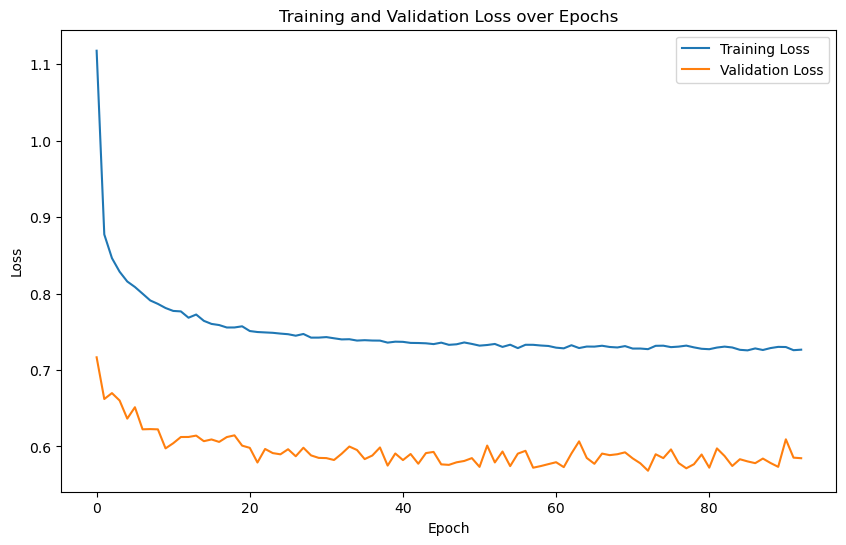

In [12]:
import matplotlib.pyplot as plt  # 导入 matplotlib.pyplot，而不是 matplotlib

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.savefig('../loss_curve_fig/merfish_human_neocortex_random_mask_finetune_full_loss_curve.png', dpi=400)  # 保存图像为png格式，400 dpi
plt.savefig('../loss_curve_fig/merfish_human_neocortex_random_mask_finetune_full_loss_curve.eps', format='eps', dpi=400)  # 保存图像为png格式，400 dpi

plt.show()


In [13]:
# 8. 使用 KNN 替代测试阶段的 FC 分类层
# 使用 encoder 提取训练集和测试集的 embedding
estim.model.eval()
with torch.no_grad():
    train_embeddings = estim.model.encoder(torch.tensor(X_train).float().to(device)).cpu().numpy()
    test_embeddings = estim.model.encoder(torch.tensor(X_test).float().to(device)).cpu().numpy()

In [14]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

    

    # 初始化和训练KNN分类器
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_embeddings, y_train)
    
    # 模型预测
predictions = knn.predict(test_embeddings)

    # 计算准确率和 F1 分数
accuracy = accuracy_score(y_test, predictions)
print(f"KNN Accuracy on Test Data: {accuracy}")
f1 = f1_score(y_test, predictions, average='weighted')
print(f"Weighted F1 Score: {f1}")
    
macro_f1 = f1_score(y_test, predictions, average='macro')
print(f'Macro F1 Score: {macro_f1}')

    # 计算随机猜测的准确率
class_probabilities = np.bincount(y_test) / len(y_test)
random_accuracy = np.sum(class_probabilities ** 2)
print(f"Random Guess Accuracy: {random_accuracy}")

    # 生成分类报告
report = classification_report(y_test, predictions, target_names=label_encoder.classes_)
print(report)

KNN Accuracy on Test Data: 0.7995956604686921
Weighted F1 Score: 0.7991847011507971
Macro F1 Score: 0.7907265815854946
Random Guess Accuracy: 0.05408382924188506
                          precision    recall  f1-score   support

       Astrocyte-Fibrous       0.82      0.86      0.84      2056
  Astrocyte-Protoplasmic       0.78      0.79      0.79      1958
          EN-IT-Immature       0.75      0.79      0.77      3827
              EN-L2_3-IT       0.74      0.79      0.77      2843
                EN-L4-IT       0.73      0.75      0.74      2585
                EN-L5-ET       0.63      0.62      0.63        98
                EN-L5-IT       0.77      0.82      0.79      1670
              EN-L5_6-NP       0.82      0.78      0.80       344
                EN-L6-CT       0.78      0.80      0.79       778
                EN-L6-IT       0.83      0.83      0.83      1914
                  EN-L6b       0.86      0.74      0.80      1218
              EN-Newborn       0.79      0.68

In [15]:
with torch.no_grad():
    new_data_tensor = torch.tensor(new_data).float().to(device)
    SSL_embeddings = estim.model.encoder(new_data_tensor).detach().cpu().numpy()
new_adata = sc.read_h5ad(data_dir)
new_adata.obsm[f'SSL_RM_FT_{random_seed}'] = SSL_embeddings
new_adata.uns[f'RM_FT_y_test_{random_seed}'] = y_test
new_adata.uns[f'RM_FT_predictions_{random_seed}'] = predictions
new_adata.uns[f'RM_FT_target_names_{random_seed}'] = label_encoder.classes_
new_adata.uns[f'RM_FT_train_loss_{random_seed}'] = train_losses
new_adata.uns[f'RM_FT_val_loss_{random_seed}'] = val_losses
new_adata.write_h5ad(data_dir)

In [16]:

import pandas as pd
import os
import re

# 当前 Notebook 文件名
notebook_name = "MERSCOPE_human_neocortex_random_mask_fine_tune_42.ipynb"

# 初始化需要打印的值
init_train_loss = train_losses[0] if 'train_losses' in globals() else None
init_val_loss = val_losses[0] if 'val_losses' in globals() else None
converged_epoch = len(train_losses) - patience if 'train_losses' in globals() else None
converged_val_loss = best_val_loss if 'best_val_loss' in globals() else None

# 打印所有所需的指标
print("Metrics Summary:")
if 'train_losses' in globals():
    print(f"init_train_loss\tinit_val_loss\tconverged_epoch\tconverged_val_loss\tmacro_f1\tweighted_f1\tmicor_f1")
    print(f"{init_train_loss:.3f}\t{init_val_loss:.3f}\t{converged_epoch}\t{converged_val_loss:.3f}\t{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")
else:
    print(f"macro_f1\tweighted_f1\tmicor_f1")
    print(f"{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")

# 保存结果到 CSV 文件
output_data = {
    'dataset_split_random_seed': [int(random_seed)],
    'dataset': ['MERSCOPE_human_neocortex'],
    'method': [re.search(r'neocortex_(.*?)_\d+', notebook_name).group(1)],
    'init_train_loss': [init_train_loss if init_train_loss is not None else ''],
    'init_val_loss': [init_val_loss if init_val_loss is not None else ''],
    'converged_epoch': [converged_epoch if converged_epoch is not None else ''],
    'converged_val_loss': [converged_val_loss if converged_val_loss is not None else ''],
    'macro_f1': [macro_f1],
    'weighted_f1': [f1],
    'micor_f1': [accuracy]
}
output_df = pd.DataFrame(output_data)

# 保存到当前目录下名为 results 的文件夹中
if not os.path.exists('results'):
    os.makedirs('results')

csv_filename = f"results/{os.path.splitext(notebook_name)[0]}_results.csv"
output_df.to_csv(csv_filename, index=False)


Metrics Summary:
init_train_loss	init_val_loss	converged_epoch	converged_val_loss	macro_f1	weighted_f1	micor_f1
1.118	0.717	73	0.568	0.791	0.799	0.800
